In [1]:
import sys
sys.path.append('..')
import h5py
import yaml
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

from flowrec.utils import my_discrete_cmap
from flowrec.utils.system import set_gpu
from flowrec.losses import relative_error
set_gpu(1)
grey = '#808080'

# Define shared functions

In [2]:
from flowrec.sensors import griddata_periodic
import jax.numpy as jnp

def interpolate(insert_observation_fn, sensor_locs, data_shape, observed):

    sensors_loc_x, sensors_loc_y = sensor_locs

    compare_interp = []
    nt = data_shape[0]
    ndim = data_shape[-1]

    side_length = data_shape[1]
    g1,g2 = np.mgrid[-side_length:side_length*2, -side_length:side_length*2]
    
    temp_observed = np.empty(data_shape)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation_fn(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    for i in range(ndim):
        _locs = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=1)
        for t in range(nt):
            _interp = griddata_periodic(_locs,temp_observed[t,...,i][~np.isnan(temp_observed[t,...,i])],(g1,g2),'cubic',side_length)
            compare_interp.append(_interp[side_length:2*side_length,side_length:2*side_length])

    compare_interp = np.array(compare_interp)
    if ndim > 1:
        compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp, temp_observed

In [3]:
def get_sensor_locs(example_train, take_observation_fn, insert_observation_fn):

    sensors_empty = np.empty_like(example_train[[0],...])
    sensors_empty.fill(np.nan)
    grid_x, grid_y = np.mgrid[0:example_train.shape[1], 0:example_train.shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation_fn(gridx1)
    idx_y = take_observation_fn(gridy1)

    idx_x = insert_observation_fn(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])].astype(int))

    idx_y = insert_observation_fn(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])].astype(int))
    
    return [sensors_loc_x, sensors_loc_y]

In [4]:
import jax
import flowrec.training_and_states as state_utils
import flowrec.data as data_utils
def get_summary_onecase(d, predict_only=False):

    with open(Path(d,'config.yml'), 'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})
    datacfg = cfg.data_config
    mdlcfg = cfg.model_config
    traincfg = cfg.train_config

    print('Loading data')
    data, datainfo = cfg.case.dataloader(datacfg)

    _keys_to_exclude = [
        'u_train_clean',
        'u_val_clean',
        'train_minmax',
        'val_minmax',
        'u_train',
        'u_val',
        'inn_train',
        'inn_val'
    ]
    observe_kwargs = {key: value for key, value in data.items() if key not in _keys_to_exclude}
    print('Building observation functions')
    take_observation, insert_observation = cfg.case.observe(
        datacfg,
        example_pred_snapshot = data['u_train'][0,...],
        example_pin_snapshot = data['inn_train'][0,...],
        **observe_kwargs
    )
    observed_train, train_minmax = take_observation(data['u_train'], init=True)
    observed_val, val_minmax = take_observation(data['u_val'], init=True)
    data.update({
        'y_train':observed_train, # not normalised
        'y_val':observed_val, # not normalised
        'train_minmax':train_minmax,
        'val_minmax':val_minmax 
    })
    print('Building model')
    prep_data, make_model = cfg.case.select_model(datacfg = datacfg, mdlcfg = mdlcfg, traincfg = traincfg)
    data = prep_data(data, datainfo)
    mdl = make_model(mdlcfg)
    state = state_utils.restore_trainingstate(d,'state')
    inn_train = data['inn_train']
    if datacfg.snr:
        yfull_train_clean = data['u_train_clean']
    else:
        yfull_train_clean = data['u_train']

    print('Predicting')
    pred_train = []
    _t = 0
    while _t < inn_train.shape[0]:
        if (_t + 500) < inn_train.shape[0]:
            pred_train.append(
                mdl.predict(state.params, inn_train[_t:_t+500,:])
            )
        else:
            pred_train.append(
                mdl.predict(state.params, inn_train[_t:,:])
            )
        _t = _t + 500

    pred_train = np.concatenate(pred_train, axis=0)

    if cfg.data_config.normalise:
        pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)

    if predict_only:
        return pred_train
    else:
        sensor_locs = get_sensor_locs(yfull_train_clean[:5,...], take_observation, insert_observation)

        print('Interpolating from observations')
        u_interp, observed = interpolate(insert_observation, sensor_locs, yfull_train_clean.shape, observed_train)
    
        # return (clean, noisy, interp, predicted)
        return (yfull_train_clean, data['u_train'], u_interp, pred_train), datainfo, observed

In [5]:
def get_tke(ufluc, datainfo):

    k = np.fft.fftfreq(128,d=datainfo.dx)
    dk = k[3]-k[2]
    k = np.fft.fftfreq(128,d=1/128)
    kgrid1,kgrid2 = np.meshgrid(k,k)
    kgrid_magnitude = np.sqrt((kgrid1**2)+(kgrid2**2))
    kgrid_magnitude_int = kgrid_magnitude.astype('int')
    kmax = np.max(kgrid_magnitude_int)
    kbins = np.arange(kmax).astype('int')


    u_fft = np.fft.fft2(ufluc[...,:2],axes=[1,2])
    ke_fft = np.sum(u_fft * np.conj(u_fft),axis=-1).real * 0.5
    ke_avg = np.mean(ke_fft,axis=0)
    spectrum = np.zeros_like(kbins).astype('float32')
    for i in kbins:
        spectrum[i] += 0.5*np.sum(ke_avg[kgrid_magnitude_int==i])
    
    return spectrum, kbins, dk

In [6]:
p3 = re.compile('^3-')
pmean3 = re.compile('^mean3-')
pclassic = re.compile('^classic-')

def is_loss3(name):
    if re.search(p3, name):
        return True
    else:
        return False
def is_lossmean(name):
    if re.search(pmean3, name):
        return True
    else:
        return False
def is_lossclassic(name):
    if re.search(pclassic, name):
        return True
    else:
        return False

# Clean cases

## Plot summary compare loss functions

In [ ]:
results_dir = Path('../local_results/2dkol/repeat_clean_minimum')


In [ ]:
def read_summary_clean_all(d):

    with h5py.File(Path(d,'summary.h5')) as hf:
        names = np.array(hf.get('runs_name')).astype('unicode')
        l_train = np.array(hf.get('runs_loss_train'))

    loss_total_loss3 = []
    loss_rel_loss3 = []
    name_loss3 = []
    loss_total_mean3 = []
    loss_rel_mean3 = []
    name_mean3 = []
    loss_total_classic = []
    loss_rel_classic = []
    name_classic = []
    for i in range(len(names)):
        if is_loss3(names[i]):
            name_loss3.append(names[i])
            loss_total_loss3.append(np.sum(l_train[i,1:]))
            loss_rel_loss3.append(l_train[i,0])
        if is_lossmean(names[i]):
            name_mean3.append(names[i])
            loss_total_mean3.append(np.sum(l_train[i,1:]))
            loss_rel_mean3.append(l_train[i,0])
        if is_lossclassic(names[i]):
            name_classic.append(names[i])
            loss_total_classic.append(np.sum(l_train[i,1:]))
            loss_rel_classic.append(l_train[i,0])

    loss_total_loss3 = np.array(loss_total_loss3)
    loss_rel_loss3 = np.array(loss_rel_loss3)
    _sort_idx = np.argsort(loss_total_loss3)
    loss_total_loss3 = loss_total_loss3[_sort_idx]
    loss_rel_loss3 = loss_rel_loss3[_sort_idx]
    print('Best run sorted by total loss is ', name_loss3[_sort_idx[0]])
    print('Best run sorted by relative loss is ', name_loss3[np.argsort(loss_rel_loss3)[0]])


    loss_total_mean3 = np.array(loss_total_mean3)
    loss_rel_mean3 = np.array(loss_rel_mean3)
    _sort_idx = np.argsort(loss_total_mean3)
    loss_total_mean3 = loss_total_mean3[_sort_idx]
    loss_rel_mean3 = loss_rel_mean3[_sort_idx]
    print('Best run sorted by total loss is ', name_mean3[_sort_idx[0]])
    print('Best run sorted by relative loss is ', name_mean3[np.argsort(loss_rel_mean3)[0]])

    loss_total_classic = np.array(loss_total_classic)
    loss_rel_classic = np.array(loss_rel_classic)
    _sort_idx = np.argsort(loss_total_classic)
    loss_total_classic = loss_total_classic[_sort_idx]
    loss_rel_classic = loss_rel_classic[_sort_idx]
    print('Best run sorted by total loss is ', name_classic[_sort_idx[0]])
    print('Best run sorted by relative loss is ', name_classic[np.argsort(loss_rel_classic)[0]])

    summary_loss3 = {
        'loss_total': loss_total_loss3,
        'loss_rel': loss_rel_loss3
    }
    summary_mean3 = {
        'loss_total': loss_total_mean3,
        'loss_rel': loss_rel_mean3
    }
    summary_classic = {
        'loss_total': loss_total_classic,
        'loss_rel': loss_rel_classic
    }

    return summary_loss3, summary_mean3, summary_classic

In [ ]:
summary_loss3, summary_mean3, summary_classic = read_summary_clean_all(results_dir)

In [ ]:
clean_example_setup = '224-18'

In [ ]:
total_mean_loss3 = np.mean(summary_loss3['loss_total'])
rel_mean_loss3 = np.mean(summary_loss3['loss_rel'])
rel_std_loss3 = np.std(summary_loss3['loss_rel'])
total_mean_mean3 = np.mean(summary_mean3['loss_total'])
rel_mean_mean3 = np.mean(summary_mean3['loss_rel'])
rel_std_mean3 = np.std(summary_mean3['loss_rel'])
total_mean_classic = np.mean(summary_classic['loss_total'])
rel_mean_classic = np.mean(summary_classic['loss_rel'])
rel_std_classic = np.std(summary_classic['loss_rel'])

print(f'Loss3: {rel_mean_loss3:.4f}+-{rel_std_loss3:.4f}')
print(f'Mean3: {rel_mean_mean3:.4f}+-{rel_std_mean3:.4f}')
print(f'Classic: {rel_mean_classic:.4f}+-{rel_std_classic:.4f}')

In [ ]:
fig, ax = plt.subplots(1,1,sharey=True, figsize=(3,2))

ax.scatter(summary_classic['loss_total'], summary_classic['loss_rel'], label='$\mathcal{L}^c$ training',marker='s', color=my_discrete_cmap(0))
ax.scatter(summary_loss3['loss_total'], summary_loss3['loss_rel'], label='$\mathcal{L}^s$ training',marker='^', color=my_discrete_cmap(1))
ax.scatter(summary_mean3['loss_total'], summary_mean3['loss_rel'], label='$\mathcal{L}^m$ training',marker='.', color=my_discrete_cmap(2))
plt.legend()
ax.set_xlabel('Total loss')
ax.set_ylabel('Rel-l2')

plt.show()

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
violin_parts = ax.violinplot([summary_classic['loss_rel'],summary_loss3['loss_rel'],summary_mean3['loss_rel']],showmeans=True,showextrema=False)
ax.set_xticks([1,2,3],['$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$'])
ax.set_ylabel('Rel-l2')
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_color(my_discrete_cmap(i))
    # pc.set_edgecolor(my_discrete_cmap(i))

## Results of cases

## Plot best case

In [ ]:
results_loss3, datainfo, observed = get_summary_onecase(Path(results_dir,'3-'+clean_example_setup))

In [ ]:
def make_image_snapshots_clean(data, figname, t1):

    ref = data[0]
    interp = data[2]
    pred = data[3]
    fig = plt.figure(figsize=(7,4))
    grid_1 = ImageGrid(fig, (0.04,0,0.54,0.3), (1,3),cbar_mode='single', share_all=True)
    grid_2 = ImageGrid(fig, (0.04,0.31,0.54,0.3), (1,3),cbar_mode='single', share_all=True)
    grid_3 = ImageGrid(fig, (0.04,0.62,0.54,0.3), (1,3),cbar_mode='single', share_all=True)

    grid_r1 = ImageGrid(fig, (0.64,0,0.36,0.3), (1,2), cbar_mode='single', share_all=True)
    grid_r2 = ImageGrid(fig, (0.64,0.31,0.36,0.3), (1,2), cbar_mode='single', share_all=True)
    grid_r3 = ImageGrid(fig, (0.64,0.62,0.36,0.3), (1,2), cbar_mode='single', share_all=True)

    for i, grid in enumerate([grid_3,grid_2,grid_1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(ref[t1,...,i].T)
        im_interp = axes[1].imshow(interp[t1,...,i].T)
        im_pred = axes[2].imshow(pred[t1,...,i].T)
        # vmin = []
        # vmax = []
        # for im in [im_ref,im_interp,im_pred]:
        #     clims = im.get_clim()
        #     vmin.append(clims[0])
        #     vmax.append(clims[1])
        for im in [im_ref,im_interp,im_pred]:
            # im.set_clim(min(vmin),max(vmax))
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])

    for i, grid in enumerate([grid_r3,grid_r2,grid_r1]):
        imerr_interp = grid.axes_all[0].imshow(np.abs(ref[t1,...,i]-interp[t1,...,i]))
        imerr_pred = grid.axes_all[1].imshow(np.abs(ref[t1,...,i]-pred[t1,...,i]))
        for im in [imerr_interp, imerr_pred]:
            im.set_clim(imerr_interp.get_clim()[0],imerr_interp.get_clim()[1])
        grid.cbar_axes[0].colorbar(imerr_interp)
        grid.axes_all[0].set(xticks=[],yticks=[])
    fig.text(0,0.15,'$p$')
    fig.text(0,0.48,'$u_2$')
    fig.text(0,0.81,'$u_1$')
    fig.text(0.09,0.97,'Reference')
    fig.text(0.25,0.97,'Interpolated')
    fig.text(0.44,0.97,'Reconstructed')
    fig.text(0.75,0.99,'Absolute error')
    fig.text(0.66,0.93,'Interpolated')
    fig.text(0.84,0.93,'Reconstructed')
    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')
    else:
        plt.show()

In [ ]:
make_image_snapshots_clean(results_loss3, None, 17)

In [ ]:
spectrum_pred, kbins, dk = get_tke(results_loss3[3], datainfo)
spectrum_ref, _, _ = get_tke(results_loss3[0], datainfo)
spectrum_interp, _, _= get_tke(results_loss3[2], datainfo)

In [ ]:
probe = [15,39]

fig = plt.figure(figsize=(7,3))
ax1 = fig.add_subplot(122, anchor=(0.7,0.0))
# fig, (ax0, ax1) = plt.subplots(1,2,figsize=(7,3))
ax1.plot(kbins*dk, spectrum_ref, label='Referece', color=grey, alpha=0.5, linewidth=3)
ax1.plot(kbins*dk, spectrum_interp, label='Interpolated', color=my_discrete_cmap(0))
ax1.plot(kbins*dk, spectrum_pred, label='Reconstructed', color=my_discrete_cmap(1),linestyle='--')
ax1.set(yscale='log', xscale='log', xlabel='wavenumber', ylabel='TKE')
ax1.set_xlim([0.1,6.84])
ax1.legend()

ax01 = fig.add_subplot(321)
ax01.plot(results_loss3[0][:,probe[0],probe[0],0],color=grey,alpha=0.5,linewidth=5)
ax01.plot(results_loss3[2][:,probe[0],probe[0],0],color=my_discrete_cmap(0))
ax01.plot(results_loss3[3][:,probe[0],probe[0],0],color=my_discrete_cmap(1),linestyle='--')

ax02 = fig.add_subplot(323)
ax02.plot(results_loss3[0][:,probe[0],probe[0],1],color=grey,alpha=0.5,linewidth=5)
ax02.plot(results_loss3[2][:,probe[0],probe[0],1],color=my_discrete_cmap(0))
ax02.plot(results_loss3[3][:,probe[0],probe[0],1],color=my_discrete_cmap(1),linestyle='--')

ax03 = fig.add_subplot(325)
ax03.plot(results_loss3[0][:,probe[0],probe[0],2],color=grey,alpha=0.5,linewidth=5)
ax03.plot(results_loss3[2][:,probe[0],probe[0],2],color=my_discrete_cmap(0))
ax03.plot(results_loss3[3][:,probe[0],probe[0],2],color=my_discrete_cmap(1),linestyle='--')

fig.tight_layout()
plt.show()

# Noisy cases

In [7]:
def make_image_snapshots(data, figname, t1):
    # data is (ref, noisy, interp, classic, loss3, mean3)

    ref = data[0]

    fig = plt.figure(figsize=(7,7))
    
    # grids for mean
    grid_b1 = ImageGrid(fig, (0.08,0.00,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b2 = ImageGrid(fig, (0.08,0.15,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b3 = ImageGrid(fig, (0.08,0.30,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    
    # grids for snapshots
    grid_t1 = ImageGrid(fig, (0.08,0.50,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t2 = ImageGrid(fig, (0.08,0.65,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t3 = ImageGrid(fig, (0.08,0.80,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    
    # snapshots
    for i, grid in enumerate([grid_t3,grid_t2,grid_t1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(ref[t1,...,i])
        
        for j in range(1,6):
            im = axes[j].imshow(data[j][t1,...,i])
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    # mean
    for i, grid in enumerate([grid_b3,grid_b2,grid_b1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(np.mean(ref[...,i],axis=0))
        
        for j in range(1,6):
            im = axes[j].imshow(np.mean(data[j][...,i],axis=0))
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    
    fig.text(0.11,0.98,'Reference')
    fig.text(0.28,0.98,'Noisy')
    fig.text(0.41,0.98,'Interpolated')
    fig.text(0.60,0.98,'$\mathcal{L}^c$')
    fig.text(0.75,0.98,'$\mathcal{L}^s$')
    fig.text(0.9,0.98,'$\mathcal{L}^m$')
    fig.text(0.01,0.20,'Mean',rotation='vertical')
    fig.text(0.05,0.07, '$\overline{p}$')
    fig.text(0.05,0.22, '$\overline{u}_2$')
    fig.text(0.05,0.37, '$\overline{u}_1$')
    fig.text(0.01,0.70,f't={t1}',rotation='vertical')
    fig.text(0.05,0.57, '$p$')
    fig.text(0.05,0.72, '$u_2$')
    fig.text(0.05,0.87, '$u_1$')

    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')
    else:
        plt.show()

In [8]:
results_noisy_dir = Path('../local_results/2dkol/repeat_noisy')

psnr5 = re.compile('snr5')
psnr10 = re.compile('snr10')
psnr20 = re.compile('snr20')

def is_snr5(name):
    if re.search(psnr5, name):
        return True
    else:
        return False
def is_snr10(name):
    if re.search(psnr10, name):
        return True
    else:
        return False
def is_snr20(name):
    if re.search(psnr20, name):
        return True
    else:
        return False
p3n = re.compile('^loss3-')
def is_loss3_noisy(name):
    if re.search(p3n, name):
        return True
    else:
        return False

In [9]:
def read_summary_noisy_all(d, lossfn):

    is_lossfn = {'loss3': is_loss3_noisy, 'lossmean': is_lossmean, 'lossclassic': is_lossclassic}[lossfn]

    with h5py.File(Path(d,'summary.h5')) as hf:
        names = np.array(hf.get('runs_name')).astype('unicode')
        l_train = np.array(hf.get('runs_loss_train'))

    lrel_20 = []
    lp_20 = []
    ltotal_20 = []
    name_20 = []
    lrel_10 = []
    lp_10 = []
    ltotal_10 = []
    name_10 = []
    lrel_5 = []
    lp_5 = []
    ltotal_5 = []
    name_5 = []

    for i in range(len(names)):
        _snr, _lossfn = names[i].split('_')
        if is_lossfn(_lossfn):
            if is_snr20(_snr):
                name_20.append(names[i])
                ltotal_20.append(np.sum(l_train[i,1:]))
                lrel_20.append(l_train[i,0])
                lp_20.append(np.sum(l_train[i,1:3]))
            if is_snr10(_snr):
                name_10.append(names[i])
                ltotal_10.append(np.sum(l_train[i,1:]))
                lrel_10.append(l_train[i,0])
                lp_10.append(np.sum(l_train[i,1:3]))
            if is_snr5(_snr):
                name_5.append(names[i])
                ltotal_5.append(np.sum(l_train[i,1:]))
                lrel_5.append(l_train[i,0])
                lp_5.append(np.sum(l_train[i,1:3]))
    ltotal = np.array([ltotal_20,ltotal_10,ltotal_5])
    lrel = np.array([lrel_20,lrel_10,lrel_5])
    lp = np.array([lp_20,lp_10,lp_5])
    name = np.array([name_20,name_10,name_5])
    
    mintotal = np.argmin(ltotal,axis=1)
    minrel = np.argmin(lrel,axis=1)

    print('Best run sorted by total loss is ', name[[0,1,2],mintotal])
    print('Best run sorted by relative loss is ', name[[0,1,2],minrel])

    return ltotal, lrel, lp, name

In [10]:
def make_image_error(data, figname, t):
    ## results (ref, noisy, interp, classic, loss3, mean3)
    ref = data[0]

    fig = plt.figure(figsize=(7.5,5))
    # grids for mean
    grid_b1 = ImageGrid(fig, (0.07,0.00,0.58,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b2 = ImageGrid(fig, (0.07,0.15,0.58,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b3 = ImageGrid(fig, (0.07,0.30,0.58,0.14), (1,6),cbar_mode='single', share_all=True)

    grid_b1e = ImageGrid(fig, (0.71,0.00,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    grid_b2e = ImageGrid(fig, (0.71,0.15,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    grid_b3e = ImageGrid(fig, (0.71,0.30,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    
    # grids for snapshots
    grid_t1 = ImageGrid(fig, (0.07,0.50,0.58,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t2 = ImageGrid(fig, (0.07,0.65,0.58,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t3 = ImageGrid(fig, (0.07,0.80,0.58,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t1e = ImageGrid(fig, (0.71,0.50,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    grid_t2e = ImageGrid(fig, (0.71,0.65,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    grid_t3e = ImageGrid(fig, (0.71,0.80,0.29,0.14), (1,3),cbar_mode='single', share_all=True)
    
    # snapshots
    for i, grid in enumerate([grid_t3,grid_t2,grid_t1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(ref[t,...,i])
        
        for j in range(1,6):
            im = axes[j].imshow(data[j][t,...,i])
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    # snapshot error
    for i, grid in enumerate([grid_t3e,grid_t2e,grid_t1e]):
        axes = grid.axes_all
        
        lvmin = []
        lvmax = []
        for j in range(3):
            im = axes[j].imshow(np.abs(ref[t,...,i] - data[j+3][t,...,i]))
            lvmin.append(im.get_clim()[0])
            lvmax.append(im.get_clim()[1])
        for j in range(3):
            axes[j].get_images()[0].set_clim(np.min(lvmin), np.max(lvmax))
        grid.cbar_axes[0].colorbar(axes[0].get_images()[0])
        grid.axes_all[0].set(xticks=[],yticks=[])
    

    
    # mean
    for i, grid in enumerate([grid_b3,grid_b2,grid_b1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(np.mean(ref[...,i],axis=0))
        
        for j in range(1,6):
            im = axes[j].imshow(np.mean(data[j][...,i],axis=0))
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    # mean error
    for i, grid in enumerate([grid_b3e,grid_b2e,grid_b1e]):
        axes = grid.axes_all
        
        lvmin = []
        lvmax = []
        for j in range(3):
            im = axes[j].imshow(np.abs(np.mean(ref[...,i],axis=0) - np.mean(data[j+3][...,i],axis=0)))
            lvmin.append(im.get_clim()[0])
            lvmax.append(im.get_clim()[1])
        for j in range(3):
            axes[j].get_images()[0].set_clim(np.min(lvmin), np.max(lvmax))
        grid.cbar_axes[0].colorbar(axes[0].get_images()[0])
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    
    fig.text(0.09,0.98,'Reference')
    fig.text(0.20,0.98,'Noisy')
    fig.text(0.27,0.98,'Interpolated')
    fig.text(0.40,0.98,'$\mathcal{L}^c$')
    fig.text(0.49,0.98,'$\mathcal{L}^s$')
    fig.text(0.58,0.98,'$\mathcal{L}^m$')
    fig.text(0.01,0.20,'Mean',rotation='vertical')
    fig.text(0.04,0.07, '$\overline{p}$')
    fig.text(0.04,0.22, '$\overline{u}_2$')
    fig.text(0.04,0.37, '$\overline{u}_1$')
    fig.text(0.01,0.70,f't={t}',rotation='vertical')
    fig.text(0.04,0.57, '$p$')
    fig.text(0.04,0.72, '$u_2$')
    fig.text(0.04,0.87, '$u_1$')
    fig.text(0.81,0.99, 'Absolute error')
    fig.text(0.75,0.96,'$\mathcal{L}^c$')
    fig.text(0.84,0.96,'$\mathcal{L}^s$')
    fig.text(0.93,0.96,'$\mathcal{L}^m$')

    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')
    else:
        plt.show()


## Overall comparison all signal to noise ratio

In [11]:
ltn_classic, lreln_classic, lpn_classic, namen_classic = read_summary_noisy_all(results_noisy_dir, 'lossclassic')
ltn_loss3, lreln_loss3, lpn_loss3, namen_loss3 = read_summary_noisy_all(results_noisy_dir, 'loss3')
ltn_mean, lreln_mean, lpn_mean, namen_mean = read_summary_noisy_all(results_noisy_dir, 'lossmean')

Best run sorted by total loss is  ['snr20_classic-2464-658' 'snr10_classic-2464-658' 'snr5_classic-2464-658']
Best run sorted by relative loss is  ['snr20_classic-7521-42135' 'snr10_classic-7521-42135'
 'snr5_classic-2464-658']
Best run sorted by total loss is  ['snr20_loss3-2464-658' 'snr10_loss3-813-18' 'snr5_loss3-813-18']
Best run sorted by relative loss is  ['snr20_loss3-2464-658' 'snr10_loss3-540-86' 'snr5_loss3-2464-658']
Best run sorted by total loss is  ['snr20_mean3-813-18' 'snr10_mean3-2464-658' 'snr5_mean3-7521-42135']
Best run sorted by relative loss is  ['snr20_mean3-7521-42135' 'snr10_mean3-7521-42135' 'snr5_mean3-7521-42135']


In [12]:
seeds = '7521-42135'
best_noisy_run = [
    ['snr20_classic-'+seeds, 'snr10_classic-'+seeds, 'snr5_classic-'+seeds],
    ['snr20_loss3-'+seeds, 'snr10_loss3-'+seeds, 'snr5_loss3-'+seeds],
    ['snr20_mean3-'+seeds, 'snr10_mean3-'+seeds, 'snr5_mean3-'+seeds]
] #[lossfn, snr]

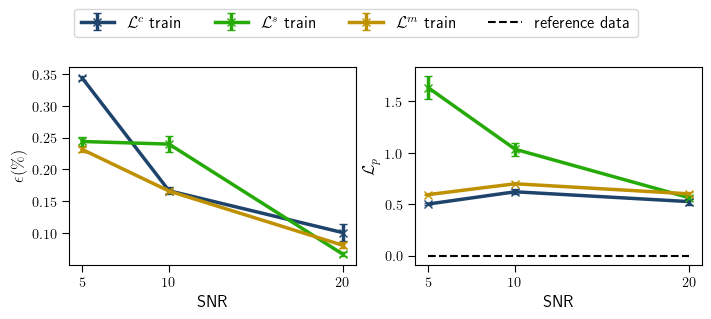

        SNR          20            10               5
lossclassic  0.101+-0.01283  0.167+-0.00546  0.344+-0.00281
loss3        0.067+-0.00256  0.240+-0.01222  0.244+-0.00782
lossmean     0.081+-0.00456  0.166+-0.00291  0.231+-0.00327


In [78]:
snr = [20,10,5]
lp_ref = 1.1317265e-05

fig, (axl, axr) = plt.subplots(1,2,figsize=(7,2.5), sharex=True)

mean_lreln_classic = np.mean(lreln_classic,axis=1)
std_lreln_classic = np.std(lreln_classic,axis=1)
mean_lreln_loss3 = np.mean(lreln_loss3,axis=1)
std_lreln_loss3 = np.std(lreln_loss3,axis=1)
mean_lreln_mean = np.mean(lreln_mean,axis=1)
std_lreln_mean = np.std(lreln_mean,axis=1)


axl.errorbar(snr,mean_lreln_classic,yerr=std_lreln_classic,label='$\mathcal{L}^c$ train',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
axl.errorbar(snr,np.mean(lreln_loss3,axis=1),yerr=np.std(lreln_loss3,axis=1),label='$\mathcal{L}^s$ train',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
axl.errorbar(snr,np.mean(lreln_mean,axis=1),yerr=np.std(lreln_mean,axis=1),label='$\mathcal{L}^m$ train',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

axl.set_ylabel('$\epsilon (\%)$')
axl.set_xticks([5,10,20])
axl.set_xlabel('SNR')

axr.errorbar(snr,np.mean(lpn_classic,axis=1),yerr=np.std(lpn_classic,axis=1),marker='x',color=my_discrete_cmap(0),linewidth=2.5)
axr.errorbar(snr,np.mean(lpn_loss3,axis=1),yerr=np.std(lpn_loss3,axis=1), marker='x',color=my_discrete_cmap(1),linewidth=2.5)
axr.errorbar(snr,np.mean(lpn_mean,axis=1),yerr=np.std(lpn_mean,axis=1),marker='x',color=my_discrete_cmap(2),linewidth=2.5)
axr.hlines(lp_ref, xmin=5,xmax=20, colors=['k'], linestyles='dashed',label='reference data')
# axr.legend(ncol=1)
axr.set_ylabel('$\mathcal{L}_p$')
axr.set_xticks([5,10,20])
axr.set_xlabel('SNR')

fig.legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.25))
# fig.savefig('./figs/2dkol_noisy_compare_lossfn',bbox_inches='tight')
plt.show()

print(f'        SNR          20            10               5')
print(f'lossclassic  {mean_lreln_classic[0]:.3f}+-{std_lreln_classic[0]:.5f}  {mean_lreln_classic[1]:.3f}+-{std_lreln_classic[1]:.5f}  {mean_lreln_classic[2]:.3f}+-{std_lreln_classic[2]:.5f}')
print(f'loss3        {mean_lreln_loss3[0]:.3f}+-{std_lreln_loss3[0]:.5f}  {mean_lreln_loss3[1]:.3f}+-{std_lreln_loss3[1]:.5f}  {mean_lreln_loss3[2]:.3f}+-{std_lreln_loss3[2]:.5f}')
print(f'lossmean     {mean_lreln_mean[0]:.3f}+-{std_lreln_mean[0]:.5f}  {mean_lreln_mean[1]:.3f}+-{std_lreln_mean[1]:.5f}  {mean_lreln_mean[2]:.3f}+-{std_lreln_mean[2]:.5f}')


## SNR10

In [14]:
results10, datainfo, observed = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[0][1]))
_results10_loss3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[1][1]), predict_only=True)
_results10_mean3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[2][1]), predict_only=True)
results10 = list(results10)
results10.append(_results10_loss3)
results10.append(_results10_mean3)

Loading data


/home/ym917/Codes/FlowReconstructionFromExperiment/figures_for_paper/../train_config/train_options/dataloader.py:228: UserWarning: Unknown command line flag '_noisy'
  warnings.warn(str(e))
/home/ym917/Codes/FlowReconstructionFromExperiment/figures_for_paper/../train_config/train_options/dataloader.py:229: UserWarning: Are you calling the dataloader from train.py?
  warnings.warn('Are you calling the dataloader from train.py?')


Building observation functions
Building model
Predicting
Interpolating from observations
Loading data
Building observation functions
Building model
Predicting
Loading data
Building observation functions
Building model
Predicting


/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


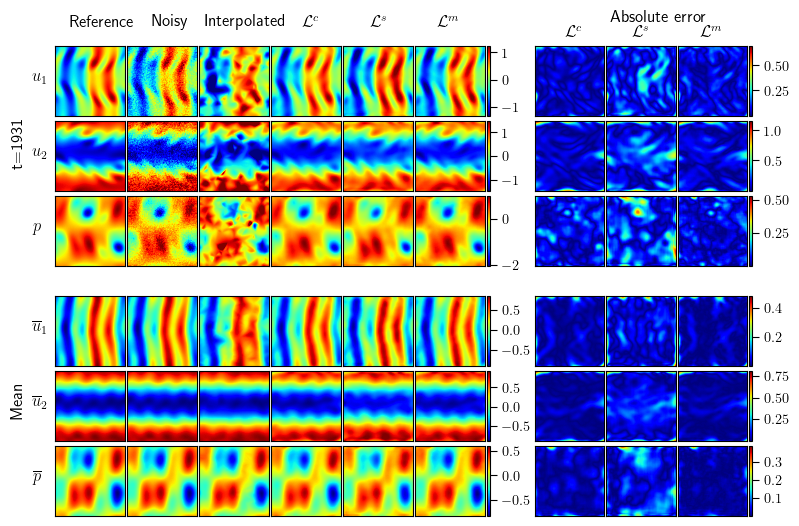

In [15]:
make_image_error(results10,None,1931)

In [16]:
results5, datainfo, observed = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[0][2]))
_results5_loss3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[1][2]), predict_only=True)
_results5_mean3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[2][2]), predict_only=True)
results5 = list(results5)
results5.append(_results5_loss3)
results5.append(_results5_mean3)

Loading data


/home/ym917/Codes/FlowReconstructionFromExperiment/figures_for_paper/../train_config/train_options/dataloader.py:228: UserWarning: Unknown command line flag '_noisy'
  warnings.warn(str(e))
/home/ym917/Codes/FlowReconstructionFromExperiment/figures_for_paper/../train_config/train_options/dataloader.py:229: UserWarning: Are you calling the dataloader from train.py?
  warnings.warn('Are you calling the dataloader from train.py?')


Building observation functions
Building model
Predicting
Interpolating from observations
Loading data
Building observation functions
Building model
Predicting
Loading data
Building observation functions
Building model
Predicting


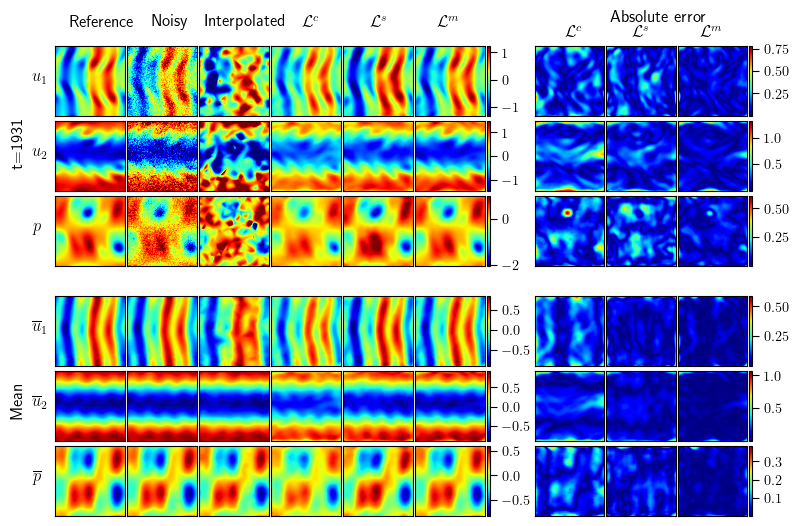

In [17]:
make_image_error(results5,None,1931)

In [18]:
relative_error(results5[-1],results5[0])

0.22887662

## SNR20

In [19]:
results20, datainfo, observed = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[0][0]))
_results20_loss3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[1][0]), predict_only=True)
_results20_mean3 = get_summary_onecase(Path(results_noisy_dir,best_noisy_run[2][0]), predict_only=True)
results20 = list(results20)
results20.append(_results20_loss3)
results20.append(_results20_mean3)

Loading data
Building observation functions
Building model
Predicting
Interpolating from observations
Loading data
Building observation functions
Building model
Predicting
Loading data
Building observation functions
Building model
Predicting


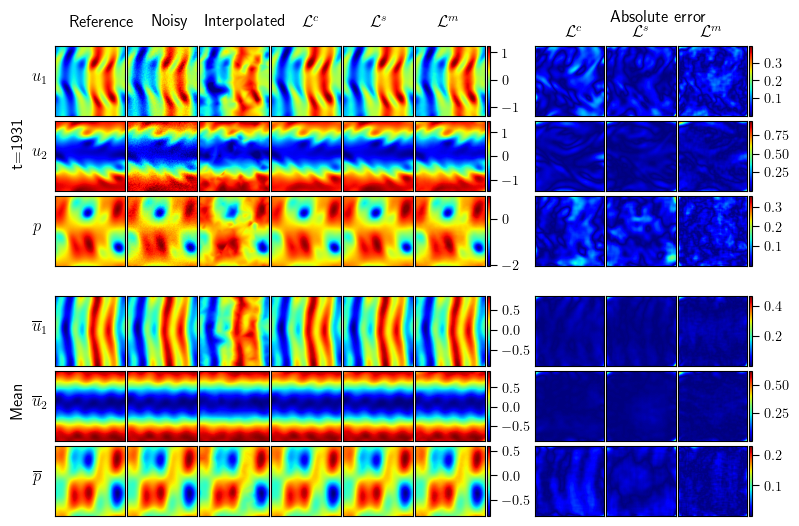

In [20]:
make_image_error(results20,None,1931)

all snr

In [21]:
## results (ref, noisy, interp, classic, loss3, mean3)

spectrum_ref, kbins, dk = get_tke(results20[0]-np.mean(results20[0],axis=0,keepdims=True), datainfo)
spectrum_interp20, _, _= get_tke(results20[2]-np.mean(results20[2],axis=0,keepdims=True), datainfo)
spectrum_lossclassic20, _, _ = get_tke(results20[3]-np.mean(results20[3],axis=0,keepdims=True), datainfo)
spectrum_loss320, _, _ = get_tke(results20[4]-np.mean(results20[4],axis=0,keepdims=True), datainfo)
spectrum_lossmean20, _, _ = get_tke(results20[5]-np.mean(results20[5],axis=0,keepdims=True), datainfo)

spectrum_interp10, _, _= get_tke(results10[2]-np.mean(results10[2],axis=0,keepdims=True), datainfo)
spectrum_lossclassic10, _, _ = get_tke(results10[3]-np.mean(results10[3],axis=0,keepdims=True), datainfo)
spectrum_loss310, _, _ = get_tke(results10[4]-np.mean(results10[4],axis=0,keepdims=True), datainfo)
spectrum_lossmean10, _, _ = get_tke(results10[5]-np.mean(results10[5],axis=0,keepdims=True), datainfo)

spectrum_interp5, _, _= get_tke(results5[2]-np.mean(results5[2],axis=0,keepdims=True), datainfo)
spectrum_lossclassic5, _, _ = get_tke(results5[3]-np.mean(results5[3],axis=0,keepdims=True), datainfo)
spectrum_loss35, _, _ = get_tke(results5[4]-np.mean(results5[4],axis=0,keepdims=True), datainfo)
spectrum_lossmean5, _, _ = get_tke(results5[5]-np.mean(results5[5],axis=0,keepdims=True), datainfo)

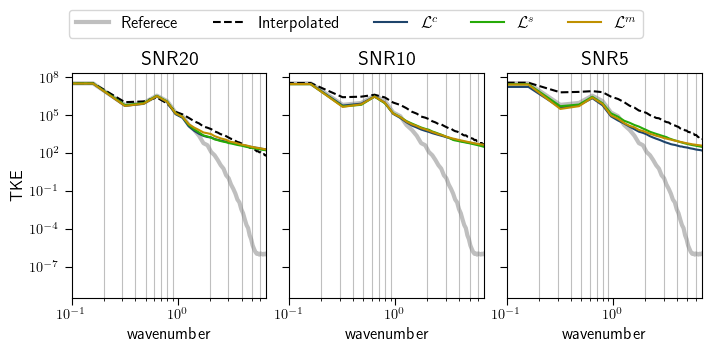

In [22]:
fig1,axes = plt.subplots(1,3,figsize=(7,3),sharey=True)

# snr20

line0, = axes[0].loglog(kbins*dk, spectrum_ref, label='Referece', color=grey, alpha=0.5, linewidth=3)
line1, = axes[0].loglog(kbins*dk, spectrum_interp20, label='Interpolated', color='k',linestyle='--')
line2, = axes[0].loglog(kbins*dk, spectrum_lossclassic20, label='$\mathcal{L}^c$', color=my_discrete_cmap(0))
line3, = axes[0].loglog(kbins*dk, spectrum_loss320, label='$\mathcal{L}^s$', color=my_discrete_cmap(1))
line4, = axes[0].loglog(kbins*dk, spectrum_lossmean20, label='$\mathcal{L}^m$', color=my_discrete_cmap(2))
axes[0].set(xlabel='wavenumber', ylabel='TKE')
axes[0].set_xlim([0.1,6.84])
axes[0].set_title('SNR20')
axes[0].grid(axis='x',which='minor')

axes[1].loglog(kbins*dk, spectrum_ref, color=grey, alpha=0.5, linewidth=3)
axes[1].loglog(kbins*dk, spectrum_interp10, color='k',linestyle='--')
axes[1].loglog(kbins*dk, spectrum_lossclassic10, color=my_discrete_cmap(0))
axes[1].loglog(kbins*dk, spectrum_loss310, color=my_discrete_cmap(1))
axes[1].loglog(kbins*dk, spectrum_lossmean10, color=my_discrete_cmap(2))
axes[1].set(xlabel='wavenumber')
axes[1].set_xlim([0.1,6.84])
axes[1].set_title('SNR10')
axes[1].grid(axis='x',which='minor')


axes[2].loglog(kbins*dk, spectrum_ref, color=grey, alpha=0.5, linewidth=3)
axes[2].loglog(kbins*dk, spectrum_interp5, color='k',linestyle='--')
axes[2].loglog(kbins*dk, spectrum_lossclassic5, color=my_discrete_cmap(0))
axes[2].loglog(kbins*dk, spectrum_loss35, color=my_discrete_cmap(1))
axes[2].loglog(kbins*dk, spectrum_lossmean5, color=my_discrete_cmap(2))
axes[2].set(xlabel='wavenumber')
axes[2].set_xlim([0.1,6.84])
axes[2].set_title('SNR5')
axes[2].grid(axis='x',which='minor')

fig1.legend(handles = [line0, line1, line2, line3, line4], ncol=5,loc='upper center', bbox_to_anchor=(0.5, 1.15))
# fig1.savefig('./figs/2dkol_noisy_tke',bbox_inches='tight')
plt.show()

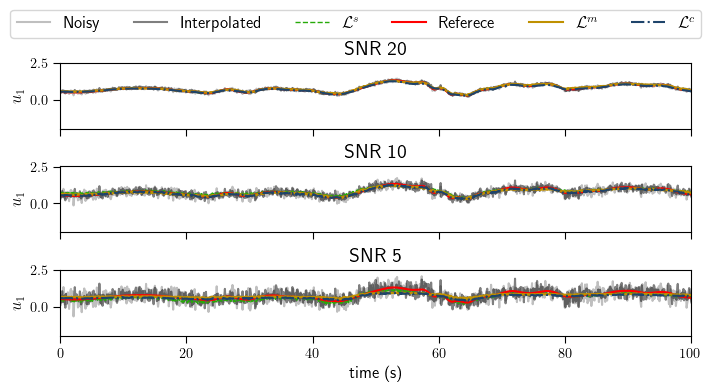

In [80]:
probex = 45
probey = 94

fig,axes = plt.subplots(3,1, figsize=(7,3.5), sharey=True, sharex=True)
realt = np.arange(results20[0].shape[0])*datainfo.dt
snr = [20,10,5]

for i, _data in enumerate([results20,results10,results5]):
    axes[i].plot(realt,_data[1][:,probex,probey,0], label='Noisy',color=grey,alpha=0.5)
    axes[i].plot(realt,_data[2][:,probex,probey,0], label='Interpolated', color='k',alpha=0.5)
    axes[i].plot(realt,_data[4][:,probex,probey,0], label='$\mathcal{L}^s$', color=my_discrete_cmap(1), linewidth=1, linestyle='--')
    axes[i].plot(realt,_data[0][:,probex,probey,0], label='Referece', color='r')
    axes[i].plot(realt,_data[5][:,probex,probey,0], label='$\mathcal{L}^m$', color=my_discrete_cmap(2), linewidth=1.5)
    axes[i].plot(realt,_data[3][:,probex,probey,0], label='$\mathcal{L}^c$', color=my_discrete_cmap(0), linewidth=1.5, linestyle='-.')
    axes[i].set_title(f'SNR {snr[i]}')
    axes[i].set_ylabel('$u_1$')

axes[2].set_xlabel('time (s)')
axes[2].set_xlim([0,100])
handles,labels = axes[0].get_legend_handles_labels()
fig.legend(handles=handles, ncol=6,loc='upper center', bbox_to_anchor=(0.5, 1.1))
plt.show()